In [ ]:
pip install criticalpath

In [2]:
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import networkx as nx
from criticalpath import Node
import plotly.express as px
from IPython.display import Image

Set up tasks with duration and define depencies

In [3]:
# set up the tasks:
tasks = [("A", {"Duration": 7}),# A: Define project scope, goals, and objectives
         ("B", {"Duration": 7}),# B: Develop project charter and risk management plan
         ("C", {"Duration": 7}),# C: Conduct needs assessment and stakeholder consultation
         ("D", {"Duration": 7}),# D: Finalize project plan and obtain stakeholder approval
         ("E", {"Duration": 49}), # E: Develop wireframes, mockups, and user interface design
         ("F", {"Duration": 224}), # F: Build backend infrastructure, database, and APIs
         ("G", {"Duration": 217}), # G: Develop content and resources for the platform
         ("H", {"Duration": 238}), # H: Develop frontend interface
         ("I", {"Duration": 105}), # I: Conduct user testing and quality assurance
         ("J", {"Duration": 28}), # J: Launch beta version for feedback and refinement
         ("K", {"Duration": 84}), # K: Develop training courses, webinars, and e-books
         ("L", {"Duration": 70}),# L: Curate resource library and knowledge hub
         ("M", {"Duration": 63}),# M: Develop community forums and engagement strategies
         ("N", {"Duration": 28}),# N: Finalize content and resources for launch
         ("O", {"Duration": 7}), # O: Launch the platform and initiate rollout plan
         ("P", {"Duration": 7}), # P: Conduct launch event and promotional activities
         ("Q", {"Duration": 7}), # Q: Monitor user feedback and adoption
        #  ("R", {"Duration": 3}), # R: Provide ongoing technical support and maintenance
        #  ("S", {"Duration": 3}), # S: Monitor platform performance and user engagement
        #  ("T", {"Duration": 3}),# T: Develop new features and content based on user feedback and needs
        #  ("U", {"Duration": 3}),# U: Evaluate impact and effectiveness of the platform
        ]

# Define the dependencies between tasks
dependencies = [
    ('A', 'B'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'E'),
    ('D', 'K'),
    ('K','L'),
    ('L', 'M'),
    ('M','N'),
    ('E', 'F'),
    ('E', 'H'),
    ('E', 'G'),
    ('F', 'J'),
    ('J', 'O'),
    ('O', 'P'),
    ('P', 'Q'),
]

# initialize (directed) graph
G = nx.DiGraph()

# add tasks and dependencies (edges)
G.add_nodes_from(tasks)
G.add_edges_from(dependencies)

Set up arbitary positions for nodes

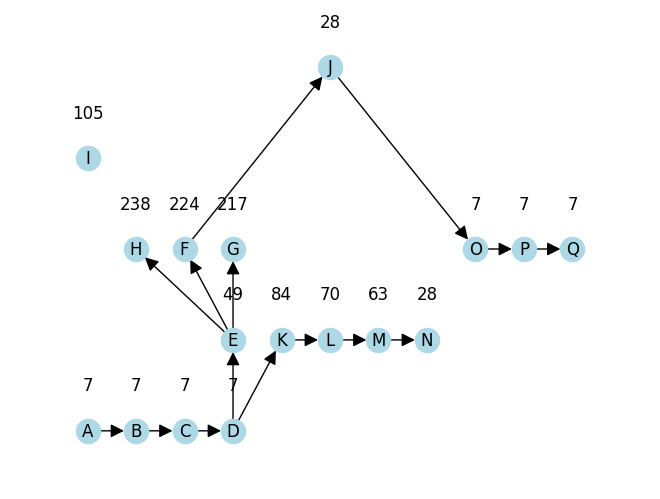

In [4]:
# set up the (arbitrary) positions of the tasks (nodes):
pos_nodes = {
             "A": (1,1),#
             "B": (2,1),#
             "C": (3,1),#
             "D": (4,1),#

             "E": (4,2),#
             "F": (3,3),#
             "G": (4,3),#

             "H": (2,3),#
             "I": (1,4),#
             "J": (6,5),#

             "K": (5,2),#
             "L": (6,2),#
             "M": (7,2),#
             "N": (8,2),#

             "O": (9,3),#
             "P": (10,3),#
             "Q": (11,3),#
             }


# draw the nodes
nx.draw(G, with_labels=True, pos=pos_nodes, node_color='lightblue', arrowsize=20)


# set up the (arbitrary) positions of the durations labels (attributes):
pos_attrs = {node:(coord[0], coord[1] + 0.5) for node, coord in pos_nodes.items()}
attrs = nx.get_node_attributes(G, 'Duration')

# draw (write) the node attributes (duration)
nx.draw_networkx_labels(G, pos=pos_attrs, labels=attrs)


# set a little margin (padding) for the graph so the labels are not cut off
plt.margins(0.1)

## Criticalpath package

In [5]:
# initialize a "project":
proj = Node('Project')

# load the tasks and their durations:
for t in tasks:
    proj.add(Node(t[0], duration=t[1]["Duration"])) # (name of the node, access the duration field of the object)

# load the dependencies (or sequence):
for d in dependencies:
    proj.link(d[0],d[1])

# update the "project":
proj.update_all()

In [6]:
# proj.get_critical_path() will return a list of nodes
# however, we want to store them as strings so that they can be easily used for visualization later
crit_path = [str(n) for n in proj.get_critical_path()]

# get the current duration of the project
proj_duration = proj.duration

print(f"The current critical path is: {crit_path}")
print(">"*50)
print(f"The current project duration is: {proj_duration} days")

The current critical path is: ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'O', 'P', 'Q']
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The current project duration is: 350 days


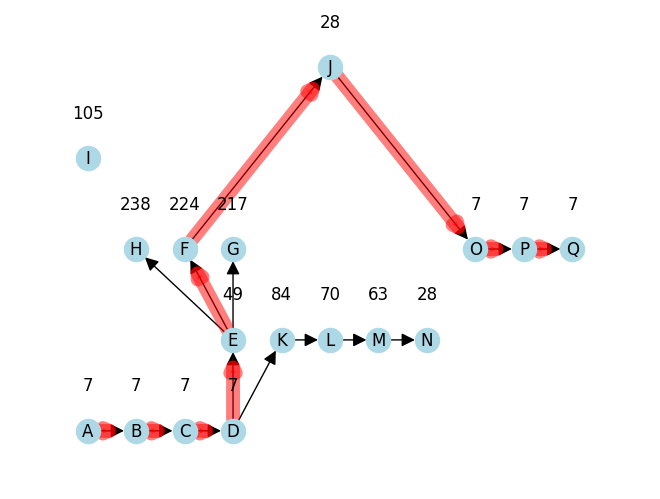

In [7]:
# create a list of edges using the current critical path list:
crit_edges = [(n, crit_path[i+1]) for i, n in enumerate(crit_path[:-1])] # [(node in CP, its successor)]
#print(crit_edges) # [('B', 'C'), ('C', 'E')]

# first, recreate the network visualization:
nx.draw(G, with_labels=True, pos=pos_nodes, node_color='lightblue', arrowsize=20)
nx.draw_networkx_labels(G, pos=pos_attrs, labels=attrs)

# now add the critical path as an additional layer on top of the original graph:
nx.draw_networkx_edges(G, pos=pos_nodes, edgelist=crit_edges, width=10, alpha=0.5, edge_color='r')
# Draws the edges only

# again, leaving some margin so the labels are not cut off
plt.margins(0.1)

An example showing the power of pandas and plotly. Results are correct, but the procedure is oversimplified ("correct" order of tasks in list is assumed)

In [8]:
from datetime import date

proj_startdate = date.today()

proj_schedule = pd.DataFrame([dict(Task = key,
                                   Start = date.fromisoformat('2022-01-02'), #datetime.date.today()
                                   Finish = date.fromisoformat('2022-01-02') + datetime.timedelta(val['Duration']),
                                   Status = 'NA')
                              for key, val in dict(tasks).items()])
# One dictionary for each line (sample)

for key, val in dict(tasks).items():
    #dep = [d for d in dependencies if d[1] == key] # all the dependencies to be paid by this task
    #prev_tasks = [t[0] for t in dep] # all the tasks on which this task depends
    prev_tasks = [d[0] for d in dependencies if d[1] == key] #
    if prev_tasks:
        prev_finish = proj_schedule[proj_schedule.Task.isin(prev_tasks)]['Finish'].max() # very powerful isin column => dataframe
        proj_schedule.loc[proj_schedule.Task == key, 'Start'] = prev_finish
        proj_schedule.loc[proj_schedule.Task == key, 'Finish'] = prev_finish + datetime.timedelta(val['Duration'])

proj_schedule.loc[proj_schedule.Task.isin(crit_path), 'Status'] = 'Critical Path'

display(proj_schedule)

,Task,Start,Finish,Status
0,A,2022-01-02,2022-01-09,Critical Path
1,B,2022-01-09,2022-01-16,Critical Path
2,C,2022-01-16,2022-01-23,Critical Path
3,D,2022-01-23,2022-01-30,Critical Path
4,E,2022-01-30,2022-03-20,Critical Path
5,F,2022-03-20,2022-10-30,Critical Path
6,G,2022-03-20,2022-10-23,NA
7,H,2022-03-20,2022-11-13,NA
8,I,2022-01-02,2022-04-17,NA
9,J,2022-10-30,2022-11-27,Critical Path


In [9]:
pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [10]:
# import kaleido
# fig = px.timeline(proj_schedule, x_start="Start", x_end="Finish", y="Task", color="Status") # by plotly.express
# fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
# Image(fig.to_image(format="png"))

import kaleido
fig = px.timeline(proj_schedule, x_start="Start", x_end="Finish", y="Task", color="Status") # by plotly.express
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
